# PEARL Fitting a Circle

In [1]:
%load_ext literary.notebook

In [2]:
import numpy as np
from scipy import optimize
import gco
from matplotlib import pyplot as plt
from matplotlib.cm import viridis

First we must load our dataset:

In [3]:
point = np.load("points.npy")

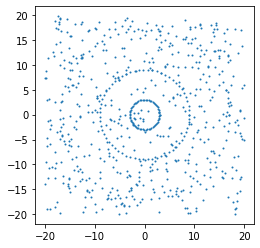

In [4]:
plt.scatter(*point, s=1)
plt.gca().set_aspect(1)

Let's create a graph of $n$ points and $m$ models, where `n = point.shape[1]` and `m` is a chosen value:

In [5]:
graph = gco.GCoptimizationGeneralGraph(point.shape[1], 128 + 1)

Let's associate a cost with each of these labels

In [6]:
label_cost = np.full(graph.num_labels, 65)
label_cost[-1] = 0.0
graph.set_label_cost(label_cost)

Now we can build a simple model class that describes points along a circle

In [7]:
class CircleModel:
    
    def __init__(self, graph, point, outlier_cost=1.0):
        self._graph = graph
        self._point = point
        self._outlier_cost = outlier_cost

In [8]:
model = CircleModel(graph, point)

We'll add the ability to label points using the graph and the current vector of optimal parameters $x$

In [9]:
@patch(CircleModel)
def compute_labelling(self, x):
    # Compute point radii
    r_x = np.sqrt(self._point[0] ** 2 + self._point[1] ** 2)
    
    # Find square of residual
    cost = (r_x[:, np.newaxis] - x[np.newaxis, :]) ** 2
    
    # Build costs
    data_cost = np.zeros((self._graph.num_sites, self._graph.num_labels))
    data_cost[:, :-1] = cost
    data_cost[:, -1] = self._outlier_cost
    self._graph.set_data_cost(data_cost)
    
    # Expand labelling
    cost = self._graph.expansion(1)
    
    return cost, self._graph.label

Let's generate some random proposals sampled from our point set, up to $n-1$ models (to account for the final outlier model)

In [10]:
i_0 = np.random.choice(np.arange(graph.num_sites), size=graph.num_labels - 1)
p_0 = np.sqrt(point[0, i_0] ** 2 + point[1, i_0] ** 2)

And colour the points according to the computed labelling

In [11]:
cost_0, label_0 = model.compute_labelling(p_0);

In [12]:
unique_label_0 = np.unique(label_0)
dense_label_0 = np.searchsorted(unique_label_0, label_0)

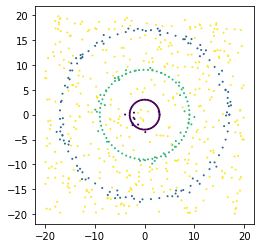

In [13]:
plt.scatter(*point, marker="o", s=1, color=viridis(dense_label_0 / (len(unique_label_0) - 1)))
plt.gca().set_aspect(1)

Now let's add the ability to refine our fit

In [14]:
@patch(CircleModel)
def optimise_parameters(self, x, label):
    x = x.copy()
    # For each model with support:
    for l in np.unique(label):
        # Ignore outlier model
        if l == len(x):
            continue

        # Minimize residual function with LSQ
        def residual(x, point):
            r = np.sqrt(point[0] ** 2 + point[1] ** 2)
            return x - r

        inlier = self._point[:, label == l]
        fit = optimize.least_squares(residual, x[l], args=(inlier,))
        
        # Store fit parameters
        x[l] = fit.x
    return x

We can implement a multi-label fit using the [PEARL algorithm](https://dl.acm.org/doi/10.1007/s11263-011-0474-7):

In [15]:
def pearl_fit(model, p):
    last_cost = np.inf
    while True:
        cost, label = model.compute_labelling(p)
        if cost >= last_cost:
            return p, label
        last_cost = cost
        p = model.optimise_parameters(p, label)

Let's evaluate the PEARL fit for our random proposals

In [16]:
p, label = pearl_fit(model, p_0)

In [17]:
p_active = p_0[np.unique(label[label != (graph.num_labels - 1)])]

In [18]:
unique_label = np.unique(label)
dense_label = np.searchsorted(unique_label, label)

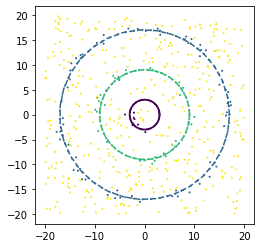

In [21]:
plt.scatter(
    *point, color=viridis(dense_label / (len(unique_label) - 1)), marker="o", s=1
)
t = np.linspace(0, 2*np.pi, 32)
for i, r in enumerate(p_active):
    plt.plot(r*np.cos(t), r*np.sin(t), "--", color=viridis(i / (len(unique_label) - 1)))
plt.gca().set_aspect(1)

Check we have three circles

In [22]:
assert len(p_active) == 3

And that we have an outlier model present

In [23]:
assert len(unique_label) == 4

And that the fit parameters lie close to the true parameters

In [24]:
assert np.allclose([3, 9, 17], np.sort(p_active), 5e-2)